In [1]:
# Preliminaries to work with the data.   
%matplotlib inline
import os
import sys
curr_path = os.getcwd()
gerkin_path = os.path.split(curr_path)[0]
olfaction_prediction_path = os.path.split(gerkin_path)[0]
sys.path.append(olfaction_prediction_path)
import opc_python
from opc_python.utils import loading, scoring
from opc_python.gerkin import dream,params
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Load and organize the features and descriptor data

In [2]:
descriptors = loading.get_descriptors(format=True)
all_CIDs = sorted(loading.get_CIDs('training')+loading.get_CIDs('leaderboard')+loading.get_CIDs('testset'))
mdx_full = dream.get_molecular_data(['dragon','episuite','morgan','nspdk','gramian'],all_CIDs)
mdx_drag_morg = dream.get_molecular_data(['dragon','morgan'],all_CIDs)
mdx_drag = dream.get_molecular_data(['dragon'],all_CIDs)

Episuite has 62 features for 476 molecules.
Morgan has 2437 features for 476 molecules.
NSPDK has 6163 features for 476 molecules.
NSPDK Gramian has 2437 features for 476 molecules.
There are now 15969 total features.
Morgan has 2437 features for 476 molecules.
There are now 7307 total features.
There are now 4870 total features.


In [3]:
# Create the feature matrices from the feature dicts.  
from sklearn.preprocessing import Imputer,MinMaxScaler
X_drag,good1,good2,means,stds,imputer = dream.make_X(mdx_drag,['training','leaderboard'])
X_drag_morg,good1,good2,means,stds,imputer = dream.make_X(mdx_drag_morg,['training','leaderboard'])
def quad_prep(mdx):
    X_temp,_,_,_,_,_ = dream.make_X(mdx,['training','leaderboard'],raw=True)
    X_temp[np.isnan(X_temp)] = 0     
    X_scaled = MinMaxScaler().fit_transform(X_temp[:,:-2])
    X_scaled_sq = np.hstack((X_scaled,X_scaled**2,X_temp[:,-2:]))
    return X_scaled_sq
X_drag_sq = quad_prep(mdx_drag)
X_drag_morg_sq = quad_prep(mdx_drag_morg)
Y_all,imputer = dream.make_Y_obs(['training','leaderboard'],target_dilution=None,imputer='mask')

The X matrix now has shape (814x3063) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x5497) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x4871) molecules by non-NaN good molecular descriptors
The X matrix now has shape (814x7308) molecules by non-NaN good molecular descriptors
The Y['mean_std'] matrix now has shape (814x42) molecules by 2 x perceptual descriptors
The Y['subject'] dict now has 49 matrices of shape (814x21) molecules by perceptual descriptors, one for each subject


## Load Gabor's feature scores and turn them into ranks

In [4]:
lin_importances = np.zeros((250,21,14613)) # 10 splits, 21 descriptors, 14613 features without the leak (7606*2 + negLogD)
lin_ranked = np.zeros((250,21,14613)).astype(int) # Matrix to store the score rankings.  
lin_features = pd.read_csv('../../data/linear_scores_and_features/features_dragon_morgan.csv',nrows=0)
for split in range(250):
    if split % 25 == 0:
        print("Finished loading the first %d splits" % split)
    for desc in range(21):
        scores = pd.read_csv('../../data/linear_scores_and_features/LB_scores_morgan%d/scores_%d.csv' % (split,desc),index_col=0)
        if 'Intensity' in scores.index:
            scores.drop(['0','Intensity'],inplace=1) # Get rid of that weird "0" feature and the leak feature.  
        if 'neglog10d' not in scores.index:
            scores.loc[14612] = 1 # Add in the dilution if it isn't there.  Assume it is as important as possible.  
        scores['int'] = np.arange(14613).astype(int) # Temp index to use for ranking.  
        lin_ranked[split,desc,:] = scores.sort_values(by='0',ascending=0)['int'] # Sort and store the ranking.  

Finished loading the first 0 splits
Finished loading the first 25 splits
Finished loading the first 50 splits
Finished loading the first 75 splits
Finished loading the first 100 splits
Finished loading the first 125 splits
Finished loading the first 150 splits
Finished loading the first 175 splits
Finished loading the first 200 splits
Finished loading the first 225 splits


In [5]:
lin_ranked[0,0,:] # The feature ranking for the first split, for intensity. 
                  # negLogD (14612) should appear first if this is working.  

array([14612,  5847,  3552, ...,  5097,  5098,  7306])

## Create the train/test splitter and a function for computing the correlation as a function of the number of features

In [6]:
from sklearn.cross_validation import ShuffleSplit
from sklearn.linear_model import Ridge
from sklearn.feature_selection import RFE
from sklearn.linear_model import RandomizedLasso

n_features = [1,2,3,4,5,10,33,100,333,1000,3333,10000]
n_splits = 25

# This class produces a new iterator that makes sure that the training and test set do not contains the same molecule
# at different dilutions, and also that the higher concentration is tested (or 10^-3 for intensity).  
class DoubleSS:
    def __init__(self, ss, col, concs):
        self.splits = ss
        self.col = col
        self.concs = concs

    def __iter__(self):
        for train, test in self.splits:
            train = np.concatenate((2*train,2*train+1))
            if self.col>0:
                test = 2*test+1 # The second (higher) concentration of the pair
            else:
                test = np.concatenate((2*test,2*test+1))
                test = test[self.concs[test]==-3]
            yield train, test
            
    def __len__(self):
        return len(self.splits)

Y = Y_all['mean_std'] # Use the perceptual means (second 21 columns are std's which are ignored here)

In [7]:
def feature_sweep(X_all,Y,n_estimators,n_splits=n_splits,n_features=n_features,model='rf',wrong_split=False,max_features='auto',
                  max_depth=None,min_samples_leaf=1,alpha=1.0,rfe=False,use_rick_lin_ranks=False,random_state=0):
    rs = np.ma.zeros((21,len(n_features),n_splits)) # Empty matrix to store correlations.  
    n_obs = int(X_all.shape[0]/2) # Number of molecules.  
    shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.17,random_state=0) # This will produce the splits in 
                                                                               # train/test_big that I put on GitHub
    
    for col in range(0,21): # For each descriptor.  
        print(col)
        X = X_all[:,:-1] # Remove high/low dilution feature, i.e. remove the leak.
        observed = Y[:,col] # Perceptual data for this descriptor.  
        n_features_ = list(np.array(n_features)+(col==0))
        n_features
        cv = DoubleSS(shuffle_split, col, X_all[:,-2]) # Produce the correct train and test indices.  
        for j,(train,test) in enumerate(cv):
            if model == 'rf': # If the model is random forest regression.  
                if col==0:
                    est = ExtraTreesRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf,n_jobs=8,random_state=random_state)
                else:
                    est = RandomForestRegressor(n_estimators=n_estimators,max_features=max_features,max_depth=max_depth,
                                              min_samples_leaf=min_samples_leaf,oob_score=False,n_jobs=8,random_state=random_state)
            elif model == 'ridge': # If the model is ridge regression. 
                est = Ridge(alpha=alpha,fit_intercept=True, normalize=False, 
                            copy_X=True, max_iter=None, tol=0.001, solver='auto', random_state=random_state)
            if rfe:  
                rfe = RFE(estimator=est, step=n_features_, n_features_to_select=1)
                rfe.fit(X[train,:],observed[train])    
            else:  
                est.fit(X[train,:],observed[train]) # Fit the model on the training data.  
                if model == 'rf':
                    importance_ranks = np.argsort(est.feature_importances_)[::-1] # Use feature importances to get ranks.  
                elif model == 'ridge':
                    if use_rick_lin_ranks:
                        importance_ranks = lin_ranked_rick[int(j+wrong_split) % n_splits,col,:] # Use the pre-computed ranks.
                    else:
                        importance_ranks = lin_ranked[int(j+wrong_split) % n_splits,col,:] # Use the pre-computed ranks.
            for i,n_feat in enumerate(n_features_):
                if col==0:
                    n_feat += 1 # Add one for intensity since negLogD is worthless when all concentrations are 1/1000.  
                if hasattr(est,'max_features') and est.max_features not in [None,'auto']:
                    if n_feat < est.max_features:
                        est.max_features = n_feat
                if rfe:
                    est.fit(X[train,:][:,rfe.ranking_<=(1+i)],observed[train])
                    predicted = est.predict(X[test,:][:,rfe.ranking_<=(1+i)])
                else:
                    #est.max_features = None
                    est.fit(X[train,:][:,importance_ranks[:n_feat]],
                            observed[train]) # Fit the model on the training data with max_features features.
                    predicted = est.predict(X[test,:][:,importance_ranks[:n_feat]]) # Predict the test data.  
                rs[col,i,j] = np.corrcoef(predicted,observed[test])[1,0] # Compute the correlation coefficient. 
                
        means = rs[col,:,:].mean(axis=1)
        sems = rs[col,:,:].std(axis=1)/np.sqrt(n_splits)
    return rs

## Compute and plot the correlations using Gabor's feature scores/ranks

In [8]:
# The right way (with feature scores and data from the same splits)
rs_lin_right = feature_sweep(X_drag_morg_sq,Y,50,n_splits=n_splits,model='ridge',alpha=1.0,rfe=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [9]:
# The wrong way (with feature scores and data from different splits)
rs_lin_wrong = feature_sweep(X_drag_morg_sq,Y,50,n_splits=n_splits,model='ridge',wrong_split=True,alpha=1.0,rfe=False)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [10]:
def plot(right,wrong):
    fig,axes = plt.subplots(3,7,sharex=False,sharey=True,figsize=(20,10))
    for col,ax in enumerate(axes.flat):
        ax.errorbar(n_features,right[col,:,:].mean(axis=1),right[col,:,:].std(axis=1)/np.sqrt(n_splits),color='red',label='right')
        ax.errorbar(n_features,wrong[col,:,:].mean(axis=1),wrong[col,:,:].std(axis=1)/np.sqrt(n_splits),color='blue',label='wrong')
        if col==0:
            handles, labels = ax.get_legend_handles_labels()
            lg = ax.legend(handles[0:], labels[0:], loc=4, fontsize=16)
            lg.draw_frame(False)

        ax.set_xlim(0.5,20000)
        ax.set_ylim(0,0.8)
        ax.set_yticks(np.linspace(0,0.6,4))
        ax.set_yticklabels([_ for _ in np.linspace(0,0.6,4)],size=20)
        ax.set_xticklabels(n_features,size=20)
        ax.set_xscale('log')
        ax.set_title(descriptors[col], size=25)
    plt.tight_layout()
    fig.text(0.5, -0.025, 'Number of features', ha='center', size=25)
    fig.text(-0.02, 0.5, 'Correlation', va='center', rotation='vertical', size=25);

/Users/rgerkin/Dropbox/python3/lib/python3.4/site-packages/numpy/ma/core.py:4139: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


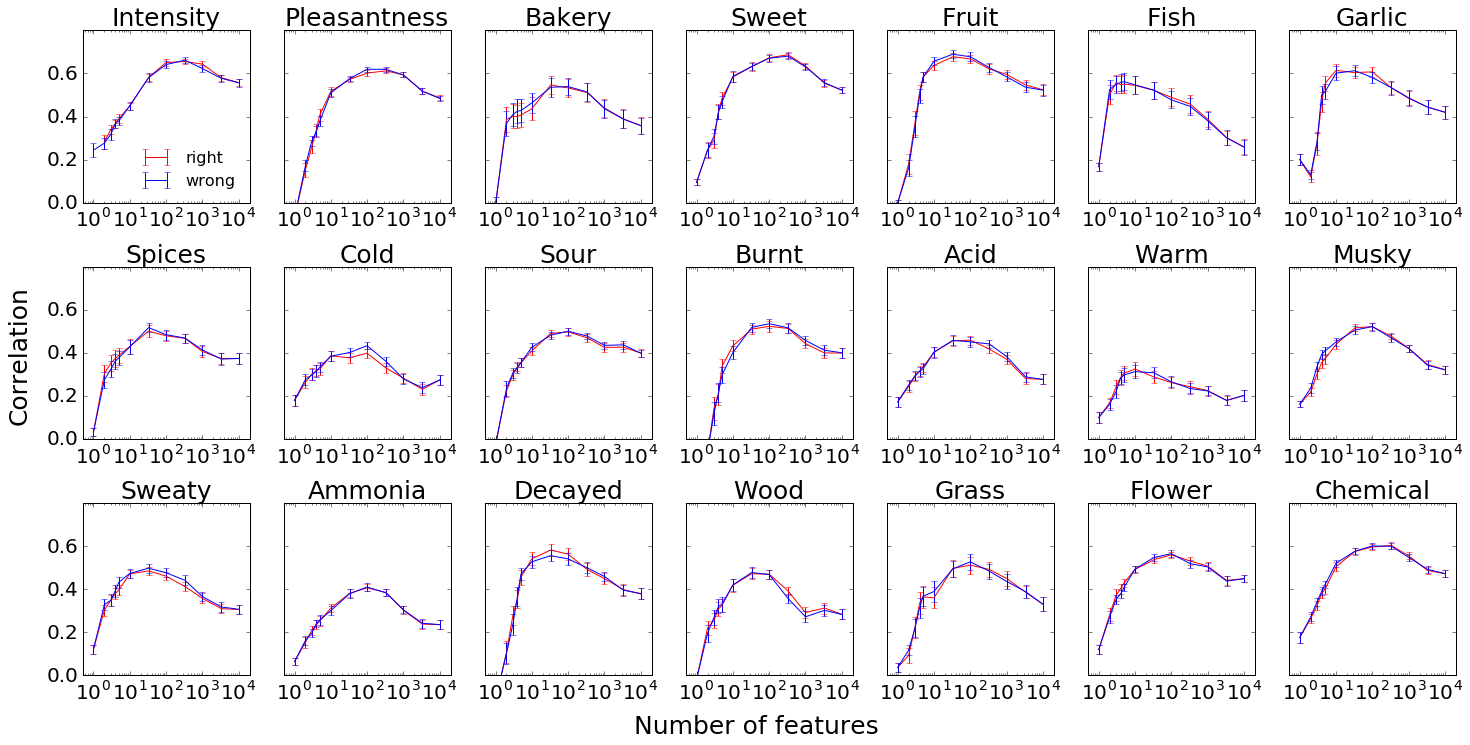

In [12]:
plot(rs_lin_right,rs_lin_wrong)

## Now let's create the splits from scratch

In [13]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [16]:
lin_ranked_rick = np.zeros((n_splits,21,14613)).astype(int) # Matrix to store the score rankings.  
rl = RandomizedLasso(alpha=0.025,selection_threshold=0.025,n_resampling=10,random_state=25,n_jobs=1)
n_obs = int(X_drag_morg_sq.shape[0]/2) # Number of molecules.  
shuffle_split = ShuffleSplit(n_obs,n_splits,test_size=0.17,random_state=0) # This will produce the splits in 
                                                                           # train/test_big that I put on GitHub
X_all = X_drag_morg_sq    
for col in range(21):
    cv = DoubleSS(shuffle_split, col, X_all[:,-2]) # Produce the correct train and test indices.  
    for j,(train,test) in enumerate(cv):
        print(descriptors[col],j)
        observed = Y[train,col]
        X = X_all[train,:-1] # Remove leak feature
        rl.fit(X,observed)
        lin_ranked_rick[j,col,:] = np.argsort(rl.all_scores_.ravel())[::-1]

Intensity 0
Intensity 1
Intensity 2
Intensity 3
Intensity 4
Intensity 5
Intensity 6
Intensity 7
Intensity 8
Intensity 9
Intensity 10
Intensity 11
Intensity 12
Intensity 13
Intensity 14
Intensity 15
Intensity 16
Intensity 17
Intensity 18
Intensity 19
Intensity 20
Intensity 21
Intensity 22
Intensity 23
Intensity 24
Pleasantness 0
Pleasantness 1
Pleasantness 2
Pleasantness 3
Pleasantness 4
Pleasantness 5
Pleasantness 6
Pleasantness 7
Pleasantness 8
Pleasantness 9
Pleasantness 10
Pleasantness 11
Pleasantness 12
Pleasantness 13
Pleasantness 14
Pleasantness 15
Pleasantness 16
Pleasantness 17
Pleasantness 18
Pleasantness 19
Pleasantness 20
Pleasantness 21
Pleasantness 22
Pleasantness 23
Pleasantness 24
Bakery 0
Bakery 1
Bakery 2
Bakery 3
Bakery 4
Bakery 5
Bakery 6
Bakery 7
Bakery 8
Bakery 9
Bakery 10
Bakery 11
Bakery 12
Bakery 13
Bakery 14
Bakery 15
Bakery 16
Bakery 17
Bakery 18
Bakery 19
Bakery 20
Bakery 21
Bakery 22
Bakery 23
Bakery 24
Sweet 0
Sweet 1
Sweet 2
Sweet 3
Sweet 4
Sweet 5
Sweet 6

## Compute and plot the correlations using my (Rick's) feature scores/ranks

In [17]:
rs_lin_rick_right = feature_sweep(X_drag_morg_sq,Y,50,n_splits=n_splits,model='ridge',wrong_split=False,alpha=1.0,rfe=False,use_rick_lin_ranks=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


In [18]:
rs_lin_rick_wrong = feature_sweep(X_drag_morg_sq,Y,50,n_splits=n_splits,model='ridge',wrong_split=True,alpha=1.0,rfe=False,use_rick_lin_ranks=True)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


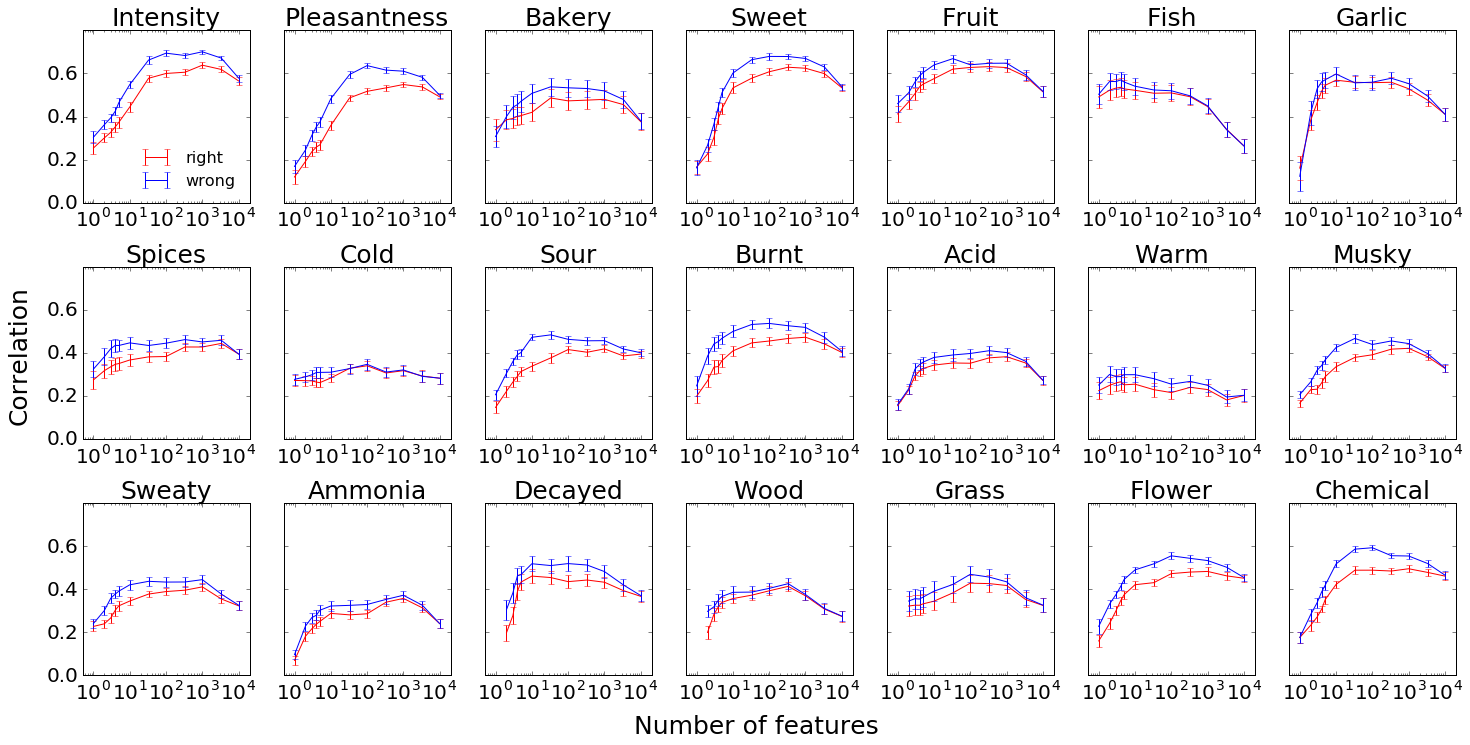

In [19]:
plot(rs_lin_rick_right,rs_lin_rick_wrong)